# Geomapviz

In [1]:
import numpy as np
import pandas as pd

# color maps, see the scicomap package as well
import cmasher as cmr
from geomapviz.shapefiles import load_shp
from geomapviz.plot import plot_on_map, facet_plot_on_map, PlotOptions

# the greatest country in the world,
# first military and economic power in the Universe
shp_file = load_shp(country="BE")
geom_df = shp_file.copy()

# create correlation with the geo entities
feat_1 = np.repeat(np.log10(geom_df.INS.astype(int).values), 10)
feat_1 = (feat_1 - feat_1.min()) / (feat_1.max() - feat_1.min())
# dummy data
X = (np.repeat(geom_df.long.values, 10) - (geom_df.long.mean())) / geom_df.long.std()
Y = (np.repeat(geom_df.lat.values, 10) - (geom_df.lat.mean())) / geom_df.lat.std()

# dummy data
bel_df = pd.DataFrame(
    {
        "geoid": np.repeat(geom_df.INS.values, 10),
        "truth": (1 - Y + X + Y**3) * np.exp(-(X**2 + Y**2)),
        "feat_2": (1 - Y**3 + X**3 + Y**5) * np.exp(-(X**2 + Y**2))
        + np.random.beta(0.5, 0.5, size=len(feat_1)),
        "feat_3": (1 + Y * X + Y**3) * np.exp(-(X**2 + Y**2))
        + np.random.beta(0.5, 0.5, size=len(feat_1)),
        "feat_4": feat_1 + np.random.beta(5, 2, size=len(feat_1)),
        "weight": np.random.random(size=len(feat_1))
        * (1 - Y + X + Y**3)
        * np.exp(-(X**2 + Y**2)),
    }
)

bel_df = bel_df.merge(
    geom_df[["INS", "borough", "district"]], left_on="geoid", right_on="INS"
)

In [2]:
bel_df.head()

geoid     truth    feat_2    feat_3    feat_4    weight    INS    borough   
0  11001  0.290799  1.347961  0.849525  0.771758  0.191747  11001  Antwerpen  \
1  11001  0.290799  0.986278  1.310067  0.560144  0.040045  11001  Antwerpen   
2  11001  0.290799  0.991139  1.566841  0.846268  0.099189  11001  Antwerpen   
3  11001  0.290799  0.361667  0.764916  0.892336  0.002305  11001  Antwerpen   
4  11001  0.290799  0.894258  0.624633  0.591308  0.225524  11001  Antwerpen   

    district  
0  Antwerpen  
1  Antwerpen  
2  Antwerpen  
3  Antwerpen  
4  Antwerpen

In [3]:
from geomapviz.aggregator import weighted_average_aggregator, dissolve_and_aggregate

geo_df = dissolve_and_aggregate(
    df=bel_df,
    target="truth",
    dissolve_on="borough",
    geoid="INS",
    weight="weight",
    shp_file=shp_file,
    distr="gaussian",
)

In [4]:
geo_df.head()

borough                                           geometry    INS LANG   
0       Aalst  POLYGON ((445410.322 6582319.436, 445370.944 6...  41002   NN  \
1      Aarlen  POLYGON ((651066.779 6376782.186, 651060.330 6...  81001   FF   
2         Aat  POLYGON ((416401.206 6532040.231, 416599.658 6...  51004   FF   
3   Antwerpen  POLYGON ((487860.579 6635693.461, 487744.668 6...  11001   NN   
4  Bastenaken  POLYGON ((639747.362 6430380.081, 639689.321 6...  82003   FF   

        Name1      Name2    Shape_Leng    Shape_Area        town        lat   
0       Aalst       None  44681.274075  7.865507e+07       AALST  50.933333  \
1       Arlon       None  63411.026552  1.191045e+08       ARLON  49.683333   
2         Ath  Vloesberg  64712.761749  1.280554e+08         ATH  50.616667   
3  Aartselaar       None  17171.876482  1.108538e+07  AARTSELAAR  51.133333   
4    Bastogne       None  71929.785657  1.730018e+08    BASTOGNE  50.000000   

       long  postcode         district   model       avg    ci_low     ci_up   
0  4.033333      9300  Oost-Vlaanderen  target -0.378398  0.000000 -0.454078  \
1  5.816667      6700        Luxemburg  target -0.002339  0.000000 -0.003000   
2  3.766667      7800       Henegouwen  target  0.145358  0.112855  0.177861   
3  4.383333      2630        Antwerpen  target  0.305202  0.269960  0.340444   
4  5.700000      6600        Luxemburg  target -0.088045  0.000000 -0.107733   

      weight  count  
0  -0.443927    100  
1  -0.025859     50  
2   3.101979     80  
3  46.660947    300  
4  -0.106431     80

In [5]:
geo_df.model.unique()

array(['target'], dtype=object)

<Axes: >

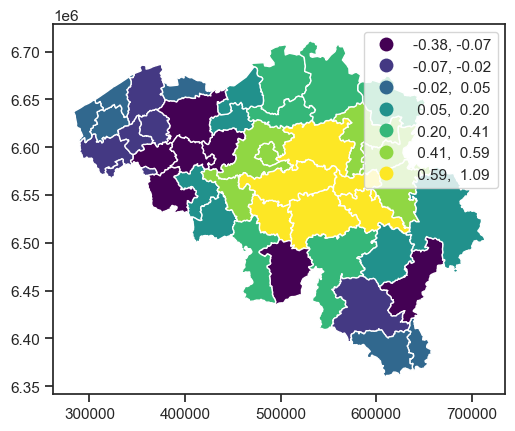

In [6]:
geo_df.plot(
    column="avg",
    scheme="quantiles",
    k=7,
    legend=True,
    legend_kwds={"loc": "best", "fmt": "{:.2f}"},
)

In [7]:
geo_df.columns

Index(['borough', 'geometry', 'INS', 'LANG', 'Name1', 'Name2', 'Shape_Leng',
       'Shape_Area', 'town', 'lat', 'long', 'postcode', 'district', 'model',
       'avg', 'ci_low', 'ci_up', 'weight', 'count'],
      dtype='object')

In [8]:
options = PlotOptions(
    # data arguments
    df=bel_df,
    target="truth",
    other_cols_avg=["feat_2", "feat_3", "feat_4"],
    # weights arguments
    weight=None,
    plot_weight=False,
    # geospatial arguments
    dissolve_on=None,
    geoid="INS",
    shp_file=shp_file,
    # uncertainty arguments
    distr="gaussian",
    plot_uncertainty=False,
    # style arguments
    background=None,
    figsize=(5, 5),
    ncols=2,
    cmap=None,
    facecolor="#2b303b",
    nbr_of_dec=None,
    # binning arguments
    autobin=False,
    normalize=False,
    n_bins=7,
)

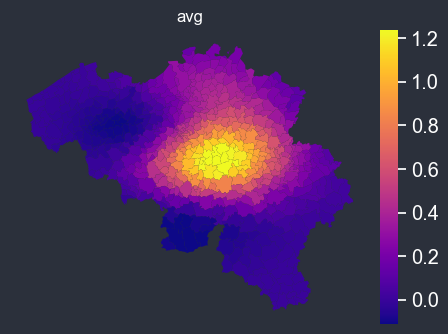

In [9]:
f = plot_on_map(options=options)

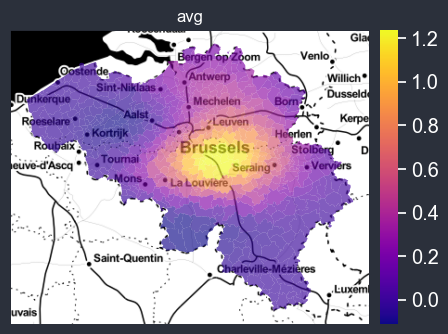

In [10]:
be_tif = "c:/Downloads/belgium_sd.tif"
options.background = be_tif

f = plot_on_map(options=options)

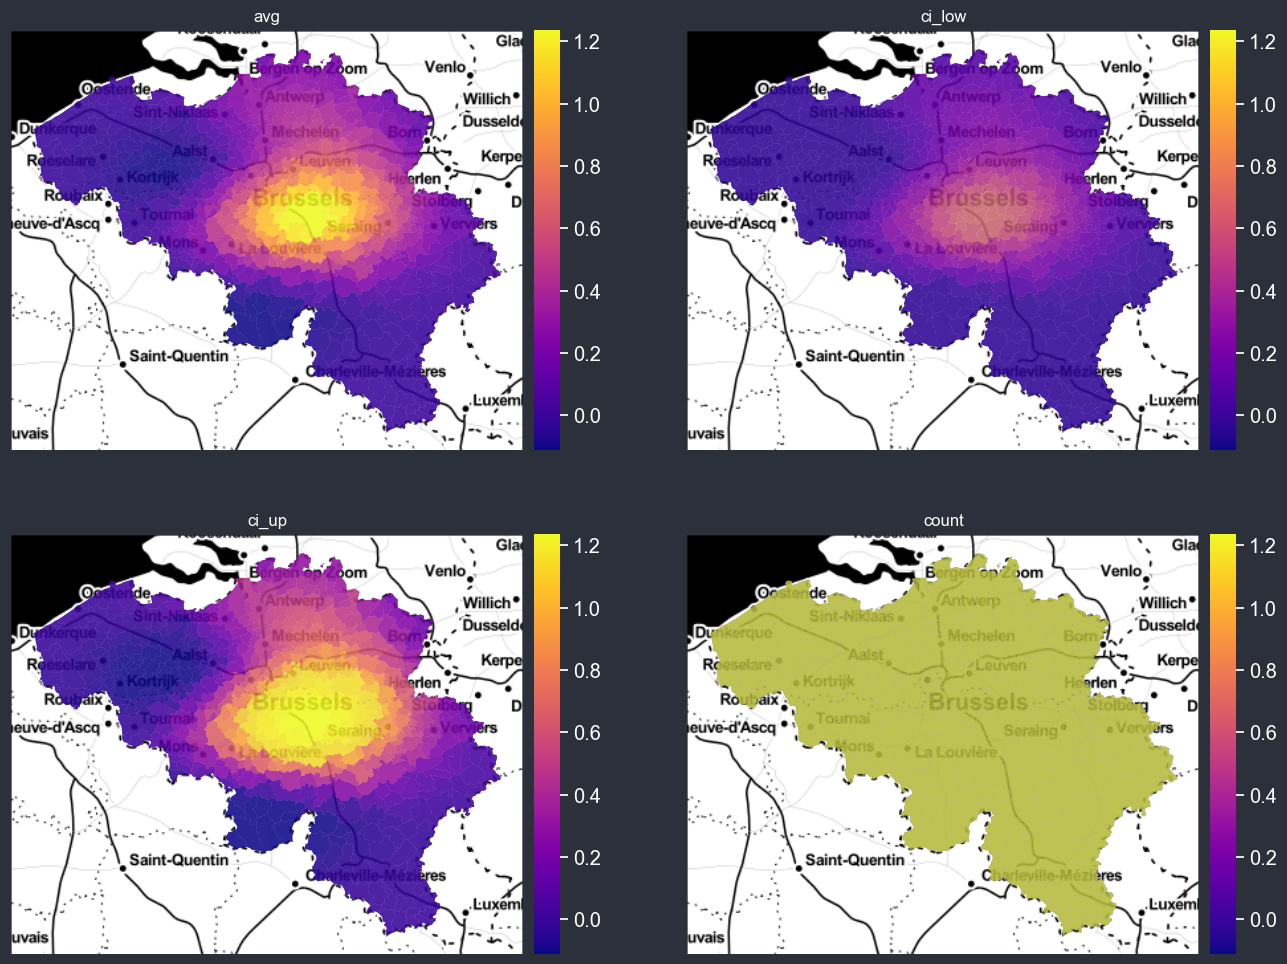

In [11]:
options.plot_uncertainty = True
options.plot_weight = True
options.autobin = False
options.normalize = True
options.figsize = (16, 12)
f = plot_on_map(options=options)

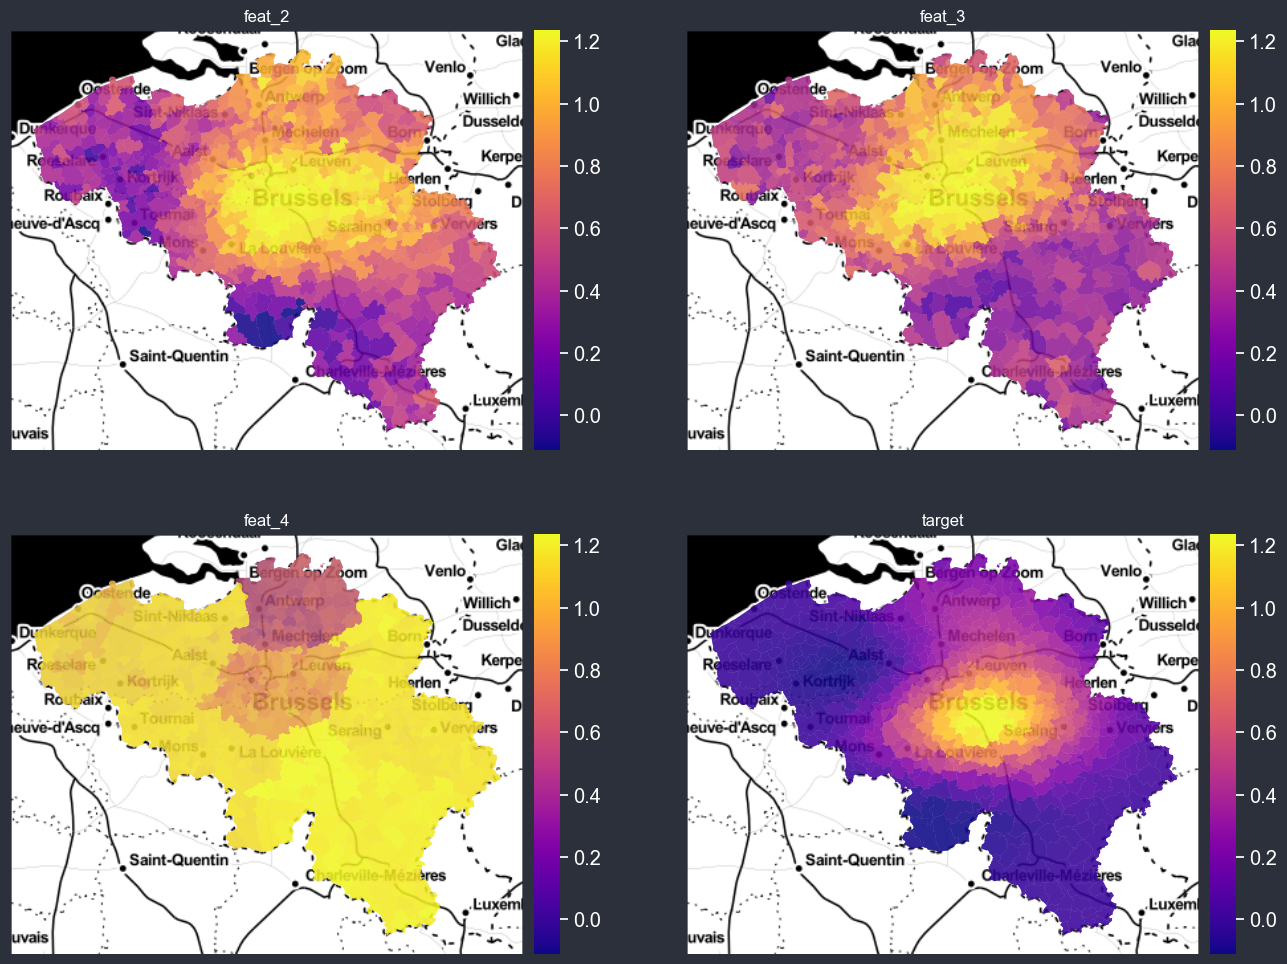

In [12]:
f = facet_plot_on_map(options=options)